Dataset:

https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv

### Import libraries and dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
housing = pd.read_csv("housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [2]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


There are 20,640 instances in the dataset. Note that the total_bedrooms attribute has only 20,433 non-zero values, which means 207 districts do not contain values. We will have to deal with that later.

All attributes are numeric except for the ocean_proximity field. Its type is an object, so it can contain any type of Python object. You can find out which categories exist in that column and how many districts belong to each category by using the value_counts() method:

In [3]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

The next step in this task of House Price Prediction is to split the data into training and test sets. Creating a test set is theoretically straightforward: select some instances at random, typically 20% of the dataset (or less if your dataset is very large), and set them aside:

In [4]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

Let’s take a closer look at the histogram of median income, as most median income values cluster around 1.5 to 6, but some median income goes well beyond 6.

It is important to have a sufficient number of instances in your dataset for each stratum, otherwise, the estimate of the importance of a stratum may be biased. This means that you should not have too many strata and that each stratum should be large enough:

<Axes: >

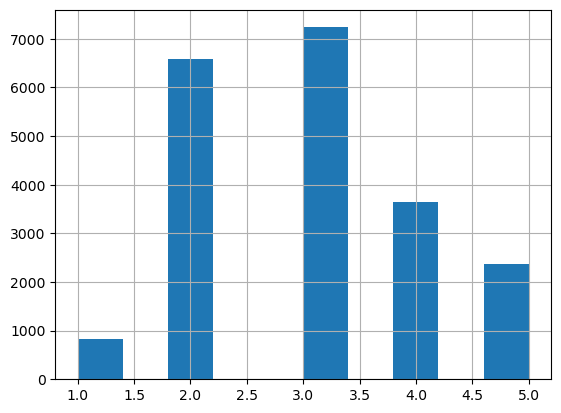

In [5]:
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1,2,3,4,5])
housing['income_cat'].hist()

### Startified Sampling on Dataset

Now the next step is to perform some stratified sampling on the dataset. But why we need to do that you can learn everything about it from [here](https://thecleverprogrammer.com/2020/12/22/stratified-sampling-with-python/). You are now ready to perform stratified sampling based on income category. For this you can use the StratifiedShuffleSplit class of Scikit-Learn:

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set  = housing.loc[test_index]
print(strat_test_set["income_cat"].value_counts() / len(strat_test_set))

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64


Now you need to remove the Income_cat attribute added by us to get the data back to its form:

In [7]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)
housing = strat_train_set.copy()

Now before creating a machine learning model for house price prediction with Python let’s visualize the data in terms of longitude and latitude:

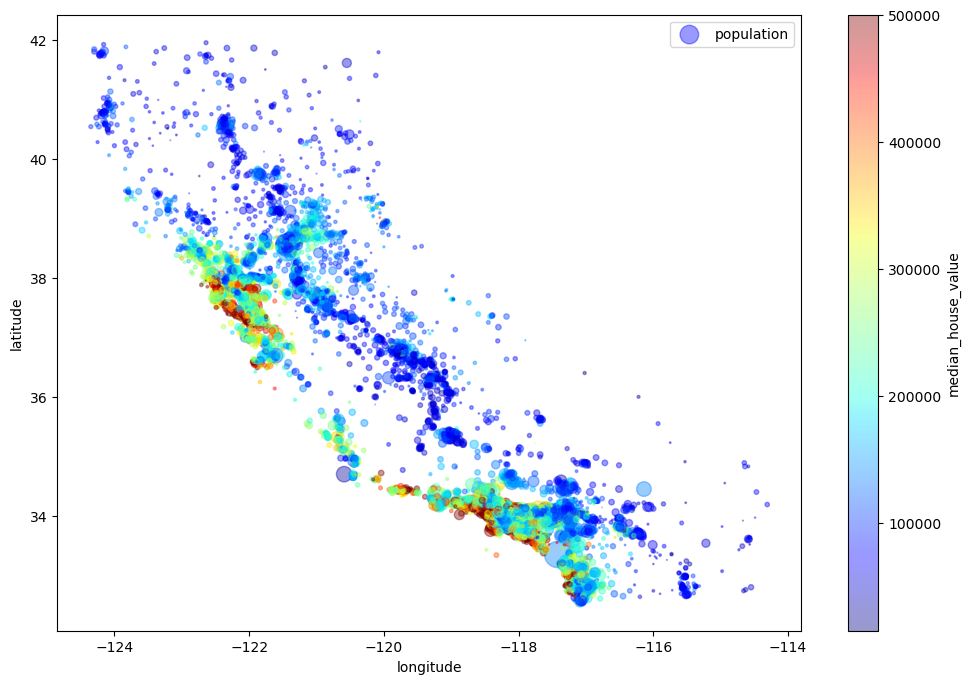

In [8]:
housing.plot(kind='scatter',x='longitude', y='latitude', alpha=0.4, s=housing['population']/100, label='population',
             figsize=(12,8), c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()
plt.show()

The graph shows house prices in California where red is expensive, blue is cheap, larger circles indicate areas with a larger population.

### Finding Correlations

Since the dataset is not too large, you can easily calculate the standard correlation coefficient between each pair of attributes using the corr() method:

In [9]:
corr_matrix = housing.corr()
print(corr_matrix.median_house_value.sort_values(ascending=False))

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64


/tmp/ipykernel_41172/1058408638.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


Correlation ranges are between -1 and 1. When it is close to 1 it means that there is a positive correlation and when it is close to -1 it means that there is a negative correlation. When it is close to 0, it means that there is no linear correlation.

Another way to check the correlation between attributes is to use the pandas scatter_matrix() function, which plots each numeric attribute against every other numeric attribute:

array([[<Axes: xlabel='longitude', ylabel='longitude'>,
        <Axes: xlabel='latitude', ylabel='longitude'>,
        <Axes: xlabel='housing_median_age', ylabel='longitude'>,
        <Axes: xlabel='total_rooms', ylabel='longitude'>,
        <Axes: xlabel='total_bedrooms', ylabel='longitude'>,
        <Axes: xlabel='population', ylabel='longitude'>,
        <Axes: xlabel='households', ylabel='longitude'>,
        <Axes: xlabel='median_income', ylabel='longitude'>,
        <Axes: xlabel='median_house_value', ylabel='longitude'>],
       [<Axes: xlabel='longitude', ylabel='latitude'>,
        <Axes: xlabel='latitude', ylabel='latitude'>,
        <Axes: xlabel='housing_median_age', ylabel='latitude'>,
        <Axes: xlabel='total_rooms', ylabel='latitude'>,
        <Axes: xlabel='total_bedrooms', ylabel='latitude'>,
        <Axes: xlabel='population', ylabel='latitude'>,
        <Axes: xlabel='households', ylabel='latitude'>,
        <Axes: xlabel='median_income', ylabel='latitude'>,
    

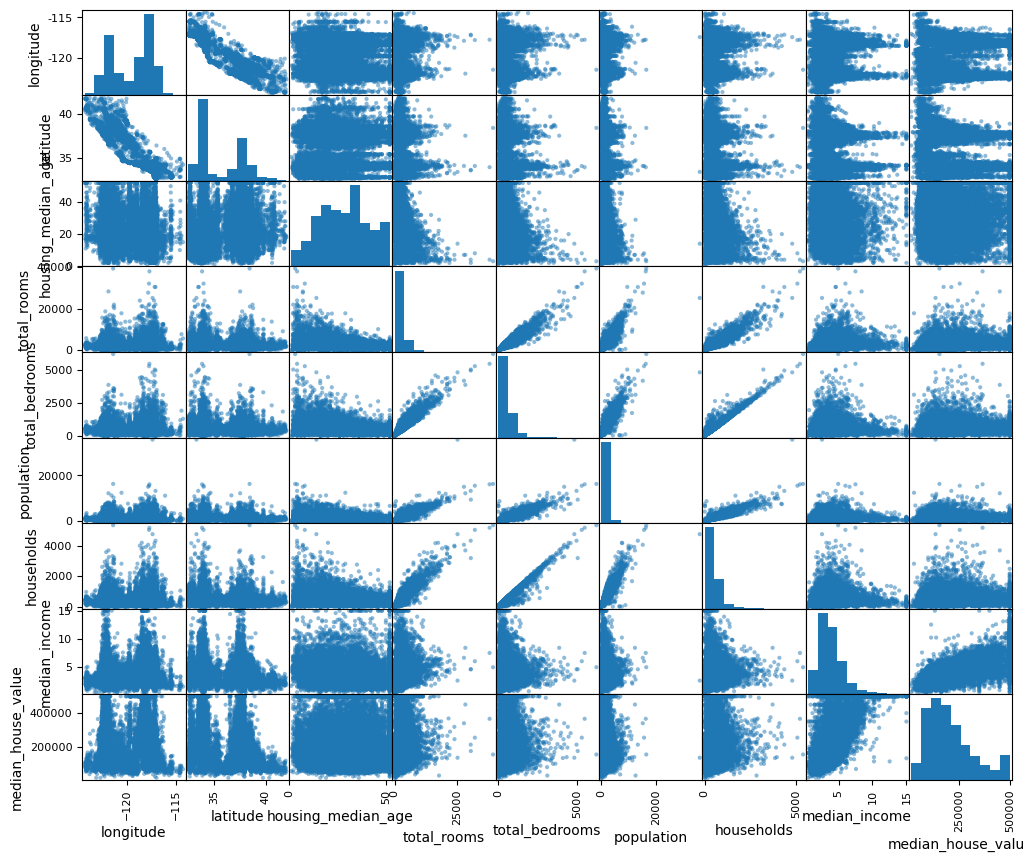

In [10]:
pd.plotting.scatter_matrix(housing, figsize=(12, 10))

And now let’s look at the correlation matrix again by adding three new columns to the dataset; rooms per household, bedrooms per room and population per household:

In [11]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

corr_matrix = housing.corr()
print(corr_matrix["median_house_value"].sort_values(ascending=False))

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64


/tmp/ipykernel_41172/1321022796.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


### Data Preparation

Now, this is the most important step before a train a machine learning model for the task of house price prediction. Now let’s perform all the necessary data transformations:

In [12]:
# Data Preparation

housing = strat_train_set.drop("median_house_value",axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)

housing_num = housing.drop("ocean_proximity", axis=True)

from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedroom_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):  # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedroom_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

As you can see, there are many data transformation steps that need to be performed in the correct order. Fortunately, Scikit-Learn provides the Pipeline class to help you with such sequences of transformations. Here is a small pipeline for numeric attributes:

In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
num_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num)

from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat",OneHotEncoder(), cat_attribs),
])
households_prepared = full_pipeline.fit_transform(housing)

### Linear Regression for House Price Prediction with Python

Now I will use the linear regression algorithm for the task of house price prediction with Python:

In [15]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(households_prepared, housing_labels)

data = housing.iloc[:5]
labels = housing_labels.iloc[:5]
data_preparation = full_pipeline.transform(data)
print("Predictions: ", lin_reg.predict(data_preparation))

Predictions:  [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]


Source:

https://thecleverprogrammer.com/2020/12/29/house-price-prediction-with-python/